# Project 3 - Solving PDEs using Physics Informed Neural Networks (PINNs)
## Model Convergence Analysis
This notebook analyzes how the prediction of the network changes with the width and number of training points of the network. 

For this implementation this means;
1. Increasing the width, i.e. number of neurons in a shallow version of the network, or;
2. Increasing the collocation points available

The notebook performs two separate analysis, starting with the width-analysis. 

#### Notebook initial imports and defaults

In [1]:
from networkFlowTorch import *
from PDEq import *
from support import *

from time import time

import autograd.numpy as anp
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

#from autograd import grad, elementwise_grad
#from sklearn.metrics import r2_score

## Random seed
default_seed = 15; anp.random.seed(default_seed)

## Figure defaults
plt.rcParams["figure.figsize"] = (5,5); plt.rcParams["font.size"] = 10

2024-12-09 19:37:50.107353: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-09 19:37:50.118007: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733769470.130447  142903 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733769470.133966  142903 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-09 19:37:50.146265: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

### Problem setup

In [2]:
## Differential equations
test_cases = ['diff1d','wave1d','wave2d','diff2d']
test = test_cases[1]

## Coefficients
c,D,amplitude = 1.,1.,1.

if test == 'diff1d':
    PDE = Diffusion1D(sim_type='flow',amp=amplitude,D=D)
    t0,tN,x0,xN = 0,1,0,1
elif test == 'wave1d':
    PDE = Wave1D(sim_type='flow',amp=amplitude,c=c)
    t0,tN,x0,xN = 0,1,-1,1
elif test == 'wave2d':
    PDE = Wave2D(sim_type='flow',amp=amplitude,c=c)
    t0,tN = 0,1
    x0,xN,y0,yN = -1,1,-1,1
elif test == 'diff2d':
    PDE = Diffusion2D(sim_type='flow',amp=amplitude,D=D)
    t0,tN = 0,1
    x0,xN,y0,yN = 0,1,0,1

## Defining the source function (necessary?)
f = PDE.right_hand_side

## Domain setup
Nt,Nx,Ny = 100,100,100

t_bound = [t0,tN]
x_bound = [x0,xN]


t = np.linspace(t_bound[0],t_bound[1],Nt)
x = np.linspace(x_bound[0],x_bound[1],Nx)

if test == 'wave2d' or test == 'diff2d':
    y_bound = [y0,yN]
    y = np.linspace(y_bound[0],y_bound[1],Ny)
    domain_array = np.array([t,x,y])
else:
    domain_array = np.array([t,x])

2024-12-09 19:38:10.281047: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


### Increasing layer size

In [ ]:
## Collocation tensor parameters
c_points = 2000; b_points = 50; i_points = 50

## Gradient descent method, regularizer and learning rate
gd_method = 'adam'
epoch = 1000
eta = 1e-1
lmbda = 1e-8

## Activation functions
hidden_func = 'gelu' # sigmoid, relu, elu, leaky_relu, tanh, swish, gelu, hard_sigmoid, exponential
act_funcs = []
act_funcs.append(hidden_func)
## Output layer activation function set to identity
act_funcs.append(None)

cost = []

layer_size = 10
for i in range(5):
    print('Layer size:',layer_size)
    layer_out_sizes = [layer_size,1]

    if test == 'wave2d' or test == 'diff2d':
            TFNetwork = FFNNetworkFlow2D(layer_output_size=layer_out_sizes,
                           activation_functions=act_funcs,
                           PDE=PDE,
                           source_function=f,
                           domain_array=domain_array,
                           domain=[x_bound,y_bound],
                           gd_method=gd_method,
                           learning_rate=eta)

            ## Setup of collocation tensor
            TFNetwork.collocation_setup(bounds=(t_bound,x_bound,y_bound), colloc_points=c_points,
                            bound_points=b_points, init_points=i_points)
    else:
        TFNetwork = FFNNetworkFlow(layer_output_size=layer_out_sizes,
                                activation_functions=act_funcs,
                                PDE=PDE,
                                source_function=f,
                                domain_array=domain_array,
                                domain=x_bound,
                                gd_method=gd_method,
                                learning_rate=eta)

        ## Setup of collocation tensor
        TFNetwork.collocation_setup(bounds=(x_bound,t_bound), colloc_points=c_points,
                                    bound_points=b_points, init_points=i_points,
                                    plot_colloc=False)

    TFNetwork.create_layers(lmbda=lmbda)

    TFNetwork.train_network(epochs=epoch)

    cost.append(TFNetwork.cost_history[-1])

    layer_size = layer_size*5

Layer size: 10
Final cost = 7.22268e-03
Layer size: 50
Final cost = 8.18558e-03
Layer size: 250
Final cost = 9.37567e-03
Layer size: 1250
Final cost = 1.08380e-02
Layer size: 6250
Final cost = 1.21917e-02


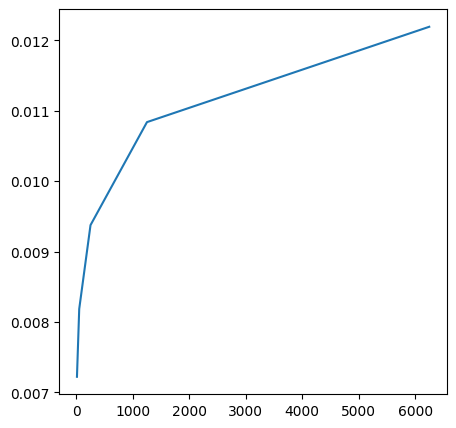

In [9]:
h = [10,50,250,1250,6250]

plt.plot(h,cost)

### Training point refinement

In [10]:
## Gradient descent method, regularizer and learning rate
gd_method = 'adam'
epoch = 1000
eta = 1e-1
lmbda = 1e-8

## Activation functions
layer_size = 20
layer_out_sizes = [layer_size,layer_size,layer_size,layer_size,1]
hidden_func = 'gelu' # sigmoid, relu, elu, leaky_relu, tanh, swish, gelu, hard_sigmoid, exponential
act_funcs = []
for _ in range(len(layer_out_sizes)-1):
    act_funcs.append(hidden_func)

## Output layer activation function set to identity
act_funcs.append(None)   

cost = []
## Collocation tensor parameters
b_points = 100; i_points = 100
c_points = 10
for i in range(5):
    print('Training points:',c_points)

    if test == 'wave2d' or test == 'diff2d':
        TFNetwork = FFNNetworkFlow2D(layer_output_size=layer_out_sizes,
                                activation_functions=act_funcs,
                                PDE=PDE,
                                source_function=f,
                                domain_array=domain_array,
                                domain=[x_bound,y_bound],
                                gd_method=gd_method,
                                learning_rate=eta)
        ## Setup of collocation tensor
        TFNetwork.collocation_setup(bounds=(t_bound,x_bound,y_bound), colloc_points=c_points,
                            bound_points=b_points, init_points=i_points)
    
    else:
        TFNetwork = FFNNetworkFlow(layer_output_size=layer_out_sizes,
                                activation_functions=act_funcs,
                                PDE=PDE,
                                source_function=f,
                                domain_array=domain_array,
                                domain=x_bound,
                                gd_method=gd_method,
                                learning_rate=eta)
        ## Setup of collocation tensor
        TFNetwork.collocation_setup(bounds=(x_bound,t_bound), colloc_points=c_points,
                                    bound_points=b_points, init_points=i_points,
                                    plot_colloc=False)

    TFNetwork.create_layers(lmbda=lmbda)

    TFNetwork.train_network(epochs=epoch)

    cost.append(TFNetwork.cost_history[-1])

    c_points = c_points*10

Training points: 10
Final cost = 9.43538e-01
Training points: 100
Final cost = 1.61104e-02
Training points: 1000
Final cost = 7.96534e-03
Training points: 10000
Final cost = 3.24865e-03
Training points: 100000
Final cost = 9.46533e-03


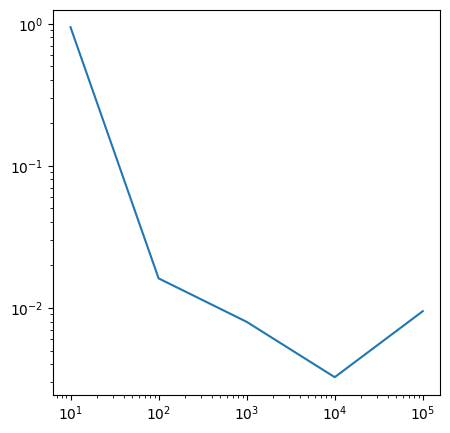

In [12]:
h = [10, 100, 1000, 10000, 100000]

plt.loglog(h,cost)

### Increasing Network depth

In [7]:
## Collocation tensor parameters
c_points = 2000; b_points = 50; i_points = 50

## Gradient descent method, regularizer and learning rate
gd_method = 'adagrad'
epoch = 1000
eta = 1e-1
lmbda = 1e-8

cost = []
## Activation functions
layer_out_sizes = [1]
layer_size = 20
for i in range(8):
    layer_out_sizes = [layer_size] + layer_out_sizes
    print('Layers:',layer_out_sizes)
    hidden_func = 'gelu' # sigmoid, relu, elu, leaky_relu, tanh, swish, gelu, hard_sigmoid, exponential
    act_funcs = []
    for _ in range(len(layer_out_sizes)-1):
        act_funcs.append(hidden_func)

    ## Output layer activation function set to identity
    act_funcs.append(None)

    if test == 'wave2d' or test == 'diff2d':
        TFNetwork = FFNNetworkFlow2D(layer_output_size=layer_out_sizes,
                                    activation_functions=act_funcs,
                                    PDE=PDE,
                                    source_function=f,
                                    domain_array=domain_array,
                                    domain=[x_bound,y_bound],
                                    gd_method=gd_method,
                                    learning_rate=eta)
        ## Setup of collocation tensor
        TFNetwork.collocation_setup(bounds=(t_bound,x_bound,y_bound), colloc_points=c_points,
                                bound_points=b_points, init_points=i_points)
    else:
        TFNetwork = FFNNetworkFlow(layer_output_size=layer_out_sizes,
                                    activation_functions=act_funcs,
                                    PDE=PDE,
                                    source_function=f,
                                    domain_array=domain_array,
                                    domain=x_bound,
                                    gd_method=gd_method,
                                    learning_rate=eta)
        ## Setup of collocation tensor
        TFNetwork.collocation_setup(bounds=(x_bound,t_bound), colloc_points=c_points,
                                    bound_points=b_points, init_points=i_points,
                                    plot_colloc=False)
            

    TFNetwork.create_layers(lmbda=lmbda)

    TFNetwork.train_network(epochs=epoch)

    cost.append(TFNetwork.cost_history[-1])

Layers: [20, 1]
Final cost = 8.04158e-03
Layers: [20, 20, 1]
Final cost = 7.54104e-03
Layers: [20, 20, 20, 1]
Final cost = 5.69029e-03
Layers: [20, 20, 20, 20, 1]
Final cost = 6.84151e-03
Layers: [20, 20, 20, 20, 20, 1]
Final cost = 4.42956e-03
Layers: [20, 20, 20, 20, 20, 20, 1]
Final cost = 5.60413e-03
Layers: [20, 20, 20, 20, 20, 20, 20, 1]
Final cost = 7.96897e-03
Layers: [20, 20, 20, 20, 20, 20, 20, 20, 1]
Final cost = 1.10136e-02


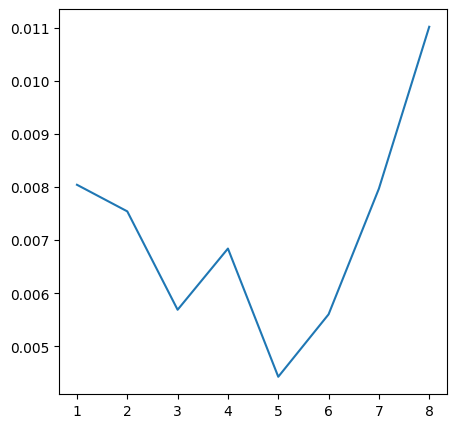

In [9]:
h = [1,2,3,4,5,6,7,8]

plt.plot(h,cost)